## Import libraries ##

In [1]:
#https://www.geeksforgeeks.org/detecting-multicollinearity-with-vif-python/

import pandas as pd
import numpy as np
import pymc3 as pm
import seaborn as sns
import matplotlib.pyplot as plt
from statsmodels.stats.outliers_influence import variance_inflation_factor   
import arviz as az

## Investigate the "average" data as a training set ##

### Load the data ###

In [2]:
cols =["Diagnosis", "radius", "texture",
       "perimeter", "area", "smoothness",
       "compactness", "concavity", "concavePoints",
       "symmetry", "fractal dimension"]

dat_avg = pd.read_csv("wdbc.data", header=None, na_values = "none",
                  usecols = [1,2,3,4,5,6,7,8,9,10,11], names=cols)
dat_avg

,Diagnosis,radius,texture,perimeter,area,smoothness,compactness,concavity,concavePoints,symmetry,fractal dimension
0,M,17.99,10.38,122.80,1001.0,0.11840,0.27760,0.30010,0.14710,0.2419,0.07871
1,M,20.57,17.77,132.90,1326.0,0.08474,0.07864,0.08690,0.07017,0.1812,0.05667
2,M,19.69,21.25,130.00,1203.0,0.10960,0.15990,0.19740,0.12790,0.2069,0.05999
3,M,11.42,20.38,77.58,386.1,0.14250,0.28390,0.24140,0.10520,0.2597,0.09744
4,M,20.29,14.34,135.10,1297.0,0.10030,0.13280,0.19800,0.10430,0.1809,0.05883
...,...,...,...,...,...,...,...,...,...,...,...
564,M,21.56,22.39,142.00,1479.0,0.11100,0.11590,0.24390,0.13890,0.1726,0.05623
565,M,20.13,28.25,131.20,1261.0,0.09780,0.10340,0.14400,0.09791,0.1752,0.05533
566,M,16.60,28.08,108.30,858.1,0.08455,0.10230,0.09251,0.05302,0.1590,0.05648
567,M,20.60,29.33,140.10,1265.0,0.11780,0.27700,0.35140,0.15200,0.2397,0.07016


### See if there are correlations between the attributes ###

In [3]:
dat_avg.corr()

,radius,texture,perimeter,area,smoothness,compactness,concavity,concavePoints,symmetry,fractal dimension
radius,1.000000,0.323782,0.997855,0.987357,0.170581,0.506124,0.676764,0.822529,0.147741,-0.311631
texture,0.323782,1.000000,0.329533,0.321086,-0.023389,0.236702,0.302418,0.293464,0.071401,-0.076437
perimeter,0.997855,0.329533,1.000000,0.986507,0.207278,0.556936,0.716136,0.850977,0.183027,-0.261477
area,0.987357,0.321086,0.986507,1.000000,0.177028,0.498502,0.685983,0.823269,0.151293,-0.283110
smoothness,0.170581,-0.023389,0.207278,0.177028,1.000000,0.659123,0.521984,0.553695,0.557775,0.584792
compactness,0.506124,0.236702,0.556936,0.498502,0.659123,1.000000,0.883121,0.831135,0.602641,0.565369
concavity,0.676764,0.302418,0.716136,0.685983,0.521984,0.883121,1.000000,0.921391,0.500667,0.336783
concavePoints,0.822529,0.293464,0.850977,0.823269,0.553695,0.831135,0.921391,1.000000,0.462497,0.166917
symmetry,0.147741,0.071401,0.183027,0.151293,0.557775,0.602641,0.500667,0.462497,1.000000,0.479921
fractal dimension,-0.311631,-0.076437,-0.261477,-0.283110,0.584792,0.565369,0.336783,0.166917,0.479921,1.000000


In [4]:
def plotCorrelationMatrix(df, graphWidth):
    corr = df.corr()
    plt.figure(num=None, figsize=(graphWidth, graphWidth), dpi=80, facecolor='w', edgecolor='k')
    corrMat = plt.matshow(corr, fignum = 1)
    plt.xticks(range(len(corr.columns)), corr.columns, rotation=90)
    plt.yticks(range(len(corr.columns)), corr.columns)
    plt.gca().xaxis.tick_bottom()
    plt.colorbar(corrMat)
    plt.show()

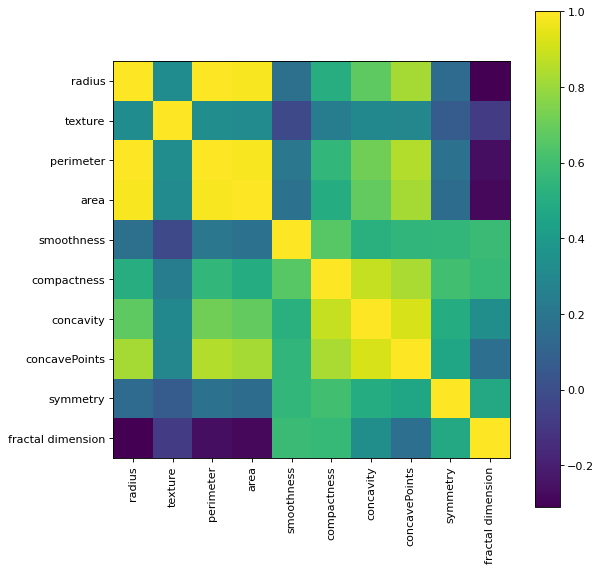

In [5]:
plotCorrelationMatrix(dat_avg, 8)

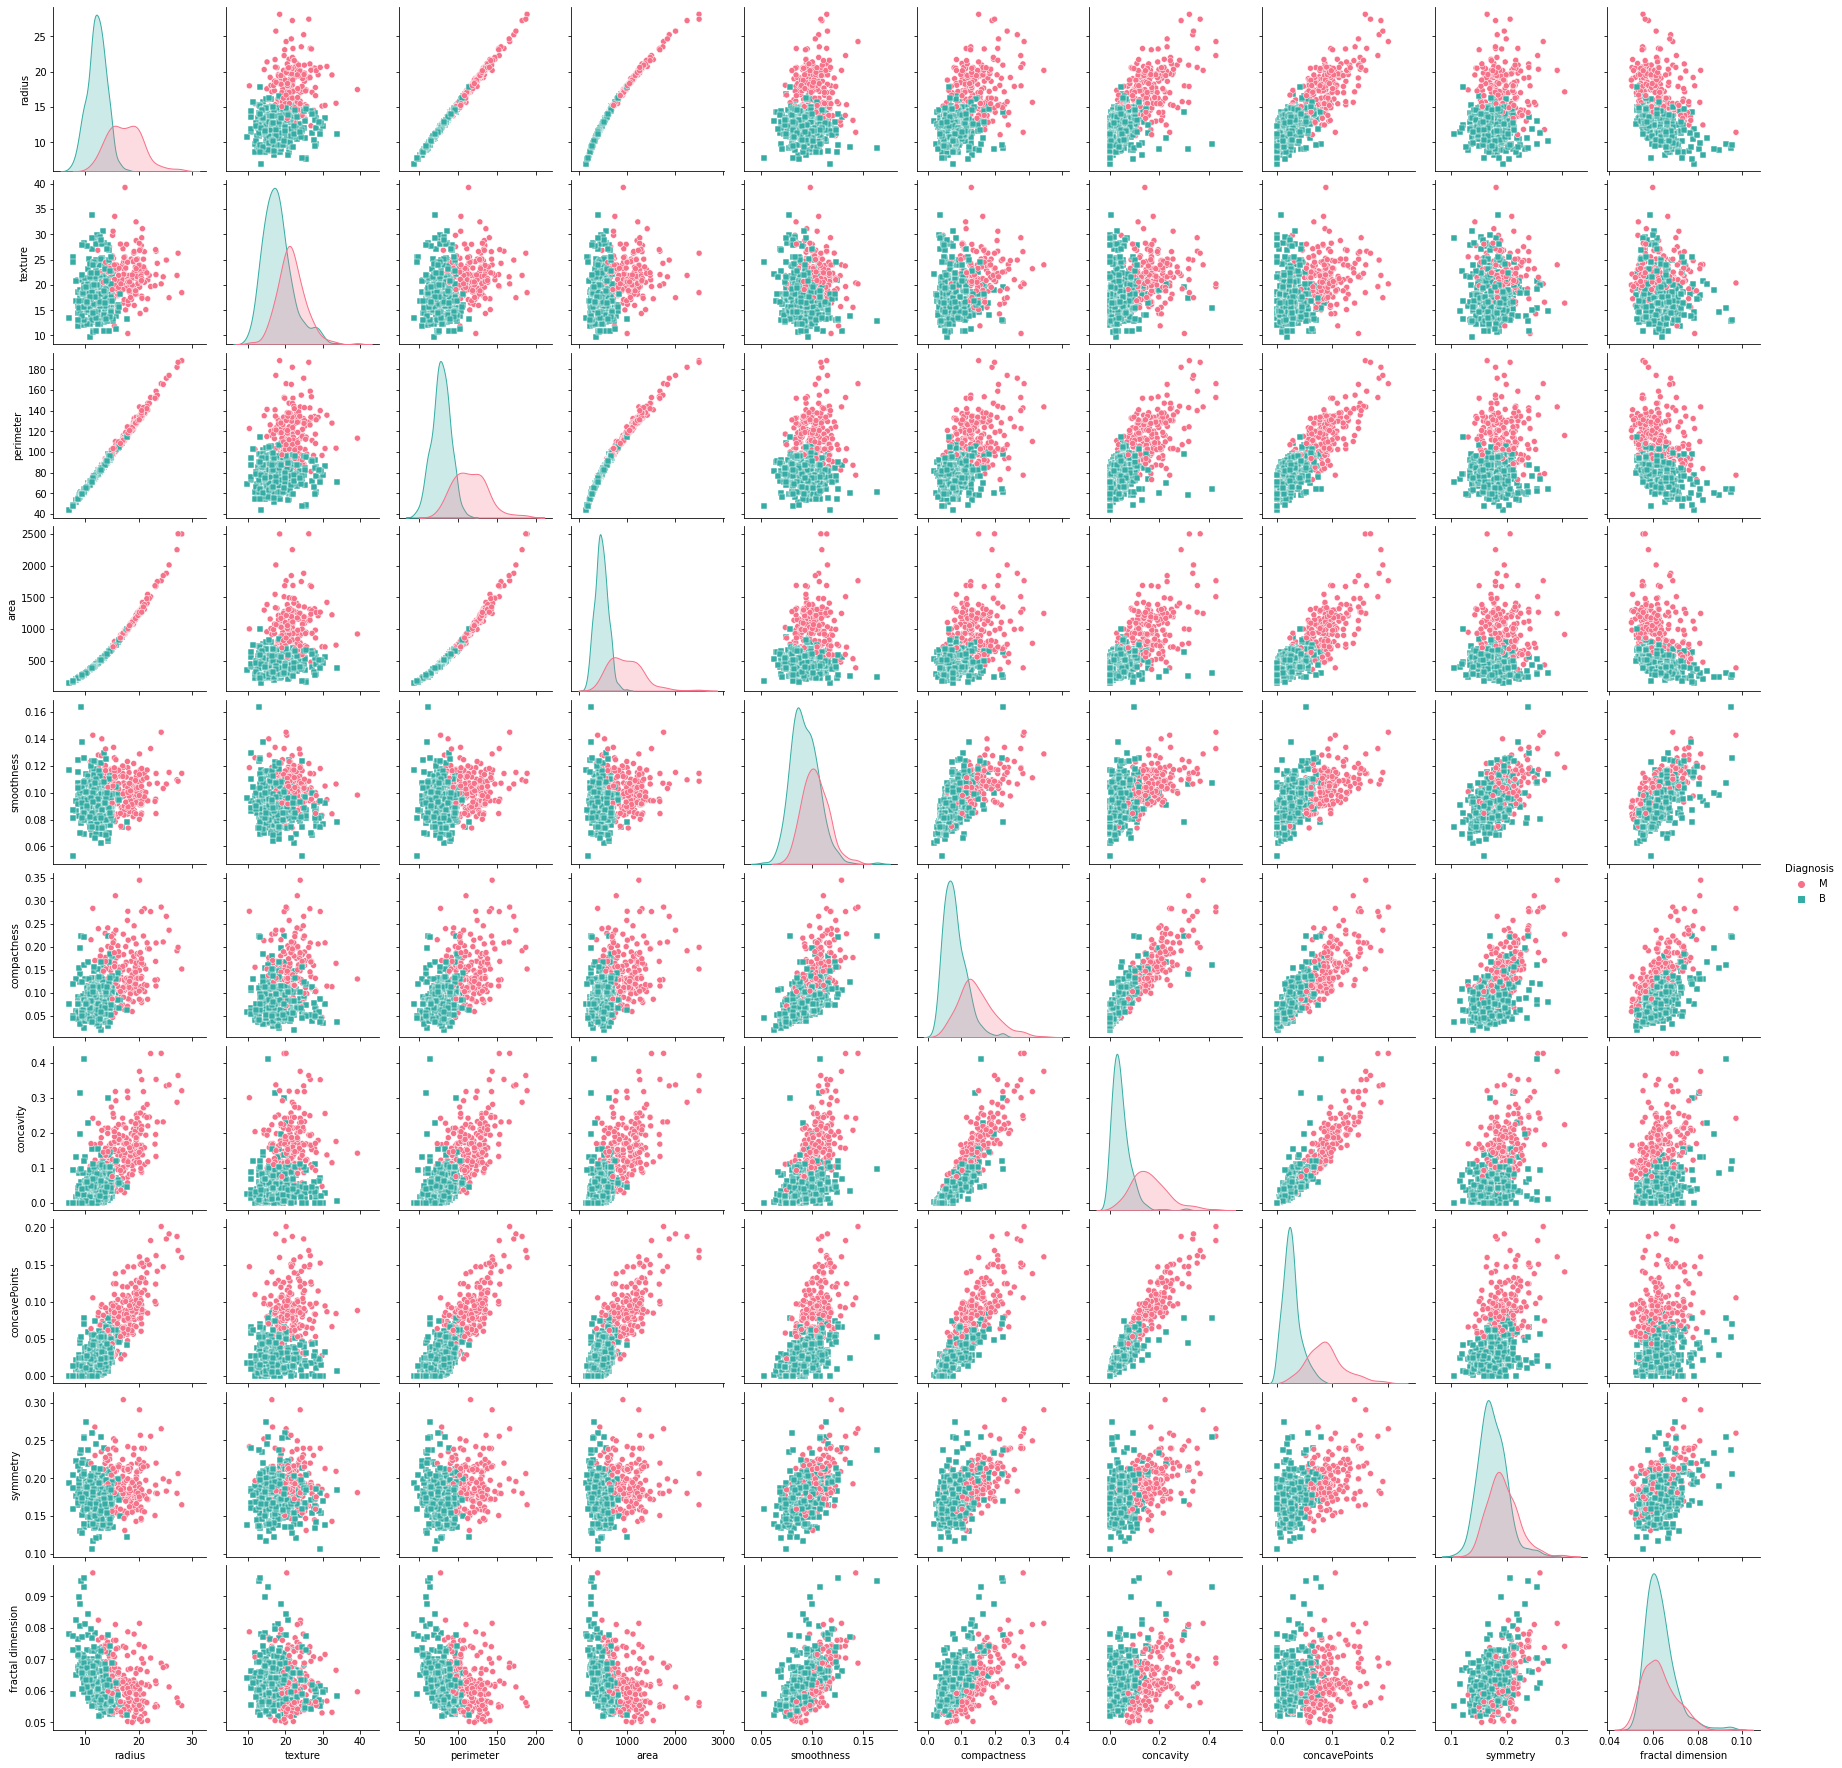

In [6]:
g = sns.pairplot(dat_avg, hue="Diagnosis", palette="husl", markers=["o", "s"])

### Run the VIF analysis iteratively, droppng the attribute with highest attribute each time. Repeat until all VIF valeus are lower than 5 ###

In [7]:
X_avg=dat_avg.drop(columns=['Diagnosis', 'symmetry', 'radius', 'perimeter',
                    'fractal dimension', 'concavePoints', 'compactness', 'texture', 'area'])
X_avg

,smoothness,concavity
0,0.11840,0.30010
1,0.08474,0.08690
2,0.10960,0.19740
3,0.14250,0.24140
4,0.10030,0.19800
...,...,...
564,0.11100,0.24390
565,0.09780,0.14400
566,0.08455,0.09251
567,0.11780,0.35140


In [8]:
vif_data = pd.DataFrame() 
vif_data["feature"] = X_avg.columns 
  
# calculating VIF for each feature 
vif_data["VIF"] = [variance_inflation_factor(X_avg.values, i) 
                          for i in range(len(X_avg.columns))] 
  
print(vif_data)

      feature       VIF
0  smoothness  2.626344
1   concavity  2.626344


## Investigate the "worst" data as a testing data ##

In [9]:
dat_worst = pd.read_csv("wdbc.data", header=None, na_values = "none",
                  usecols = [1,22,23,24,25,26,27,28,29,30,31], names=cols)
dat_worst

,Diagnosis,radius,texture,perimeter,area,smoothness,compactness,concavity,concavePoints,symmetry,fractal dimension
0,M,25.380,17.33,184.60,2019.0,0.16220,0.66560,0.7119,0.2654,0.4601,0.11890
1,M,24.990,23.41,158.80,1956.0,0.12380,0.18660,0.2416,0.1860,0.2750,0.08902
2,M,23.570,25.53,152.50,1709.0,0.14440,0.42450,0.4504,0.2430,0.3613,0.08758
3,M,14.910,26.50,98.87,567.7,0.20980,0.86630,0.6869,0.2575,0.6638,0.17300
4,M,22.540,16.67,152.20,1575.0,0.13740,0.20500,0.4000,0.1625,0.2364,0.07678
...,...,...,...,...,...,...,...,...,...,...,...
564,M,25.450,26.40,166.10,2027.0,0.14100,0.21130,0.4107,0.2216,0.2060,0.07115
565,M,23.690,38.25,155.00,1731.0,0.11660,0.19220,0.3215,0.1628,0.2572,0.06637
566,M,18.980,34.12,126.70,1124.0,0.11390,0.30940,0.3403,0.1418,0.2218,0.07820
567,M,25.740,39.42,184.60,1821.0,0.16500,0.86810,0.9387,0.2650,0.4087,0.12400


### Check if the correlations are similar to the training data ###

In [10]:
dat_worst.corr()

,radius,texture,perimeter,area,smoothness,compactness,concavity,concavePoints,symmetry,fractal dimension
radius,1.000000,0.359921,0.993708,0.984015,0.216574,0.475820,0.573975,0.787424,0.243529,0.093492
texture,0.359921,1.000000,0.365098,0.345842,0.225429,0.360832,0.368366,0.359755,0.233027,0.219122
perimeter,0.993708,0.365098,1.000000,0.977578,0.236775,0.529408,0.618344,0.816322,0.269493,0.138957
area,0.984015,0.345842,0.977578,1.000000,0.209145,0.438296,0.543331,0.747419,0.209146,0.079647
smoothness,0.216574,0.225429,0.236775,0.209145,1.000000,0.568187,0.518523,0.547691,0.493838,0.617624
compactness,0.475820,0.360832,0.529408,0.438296,0.568187,1.000000,0.892261,0.801080,0.614441,0.810455
concavity,0.573975,0.368366,0.618344,0.543331,0.518523,0.892261,1.000000,0.855434,0.532520,0.686511
concavePoints,0.787424,0.359755,0.816322,0.747419,0.547691,0.801080,0.855434,1.000000,0.502528,0.511114
symmetry,0.243529,0.233027,0.269493,0.209146,0.493838,0.614441,0.532520,0.502528,1.000000,0.537848
fractal dimension,0.093492,0.219122,0.138957,0.079647,0.617624,0.810455,0.686511,0.511114,0.537848,1.000000


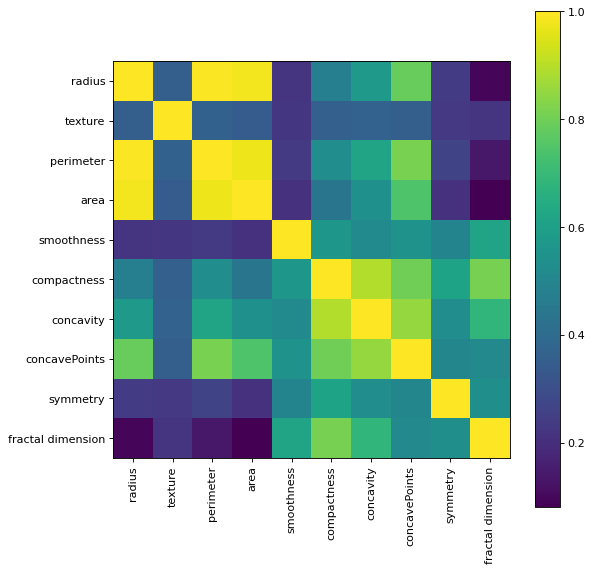

In [11]:
plotCorrelationMatrix(dat_worst, 8)

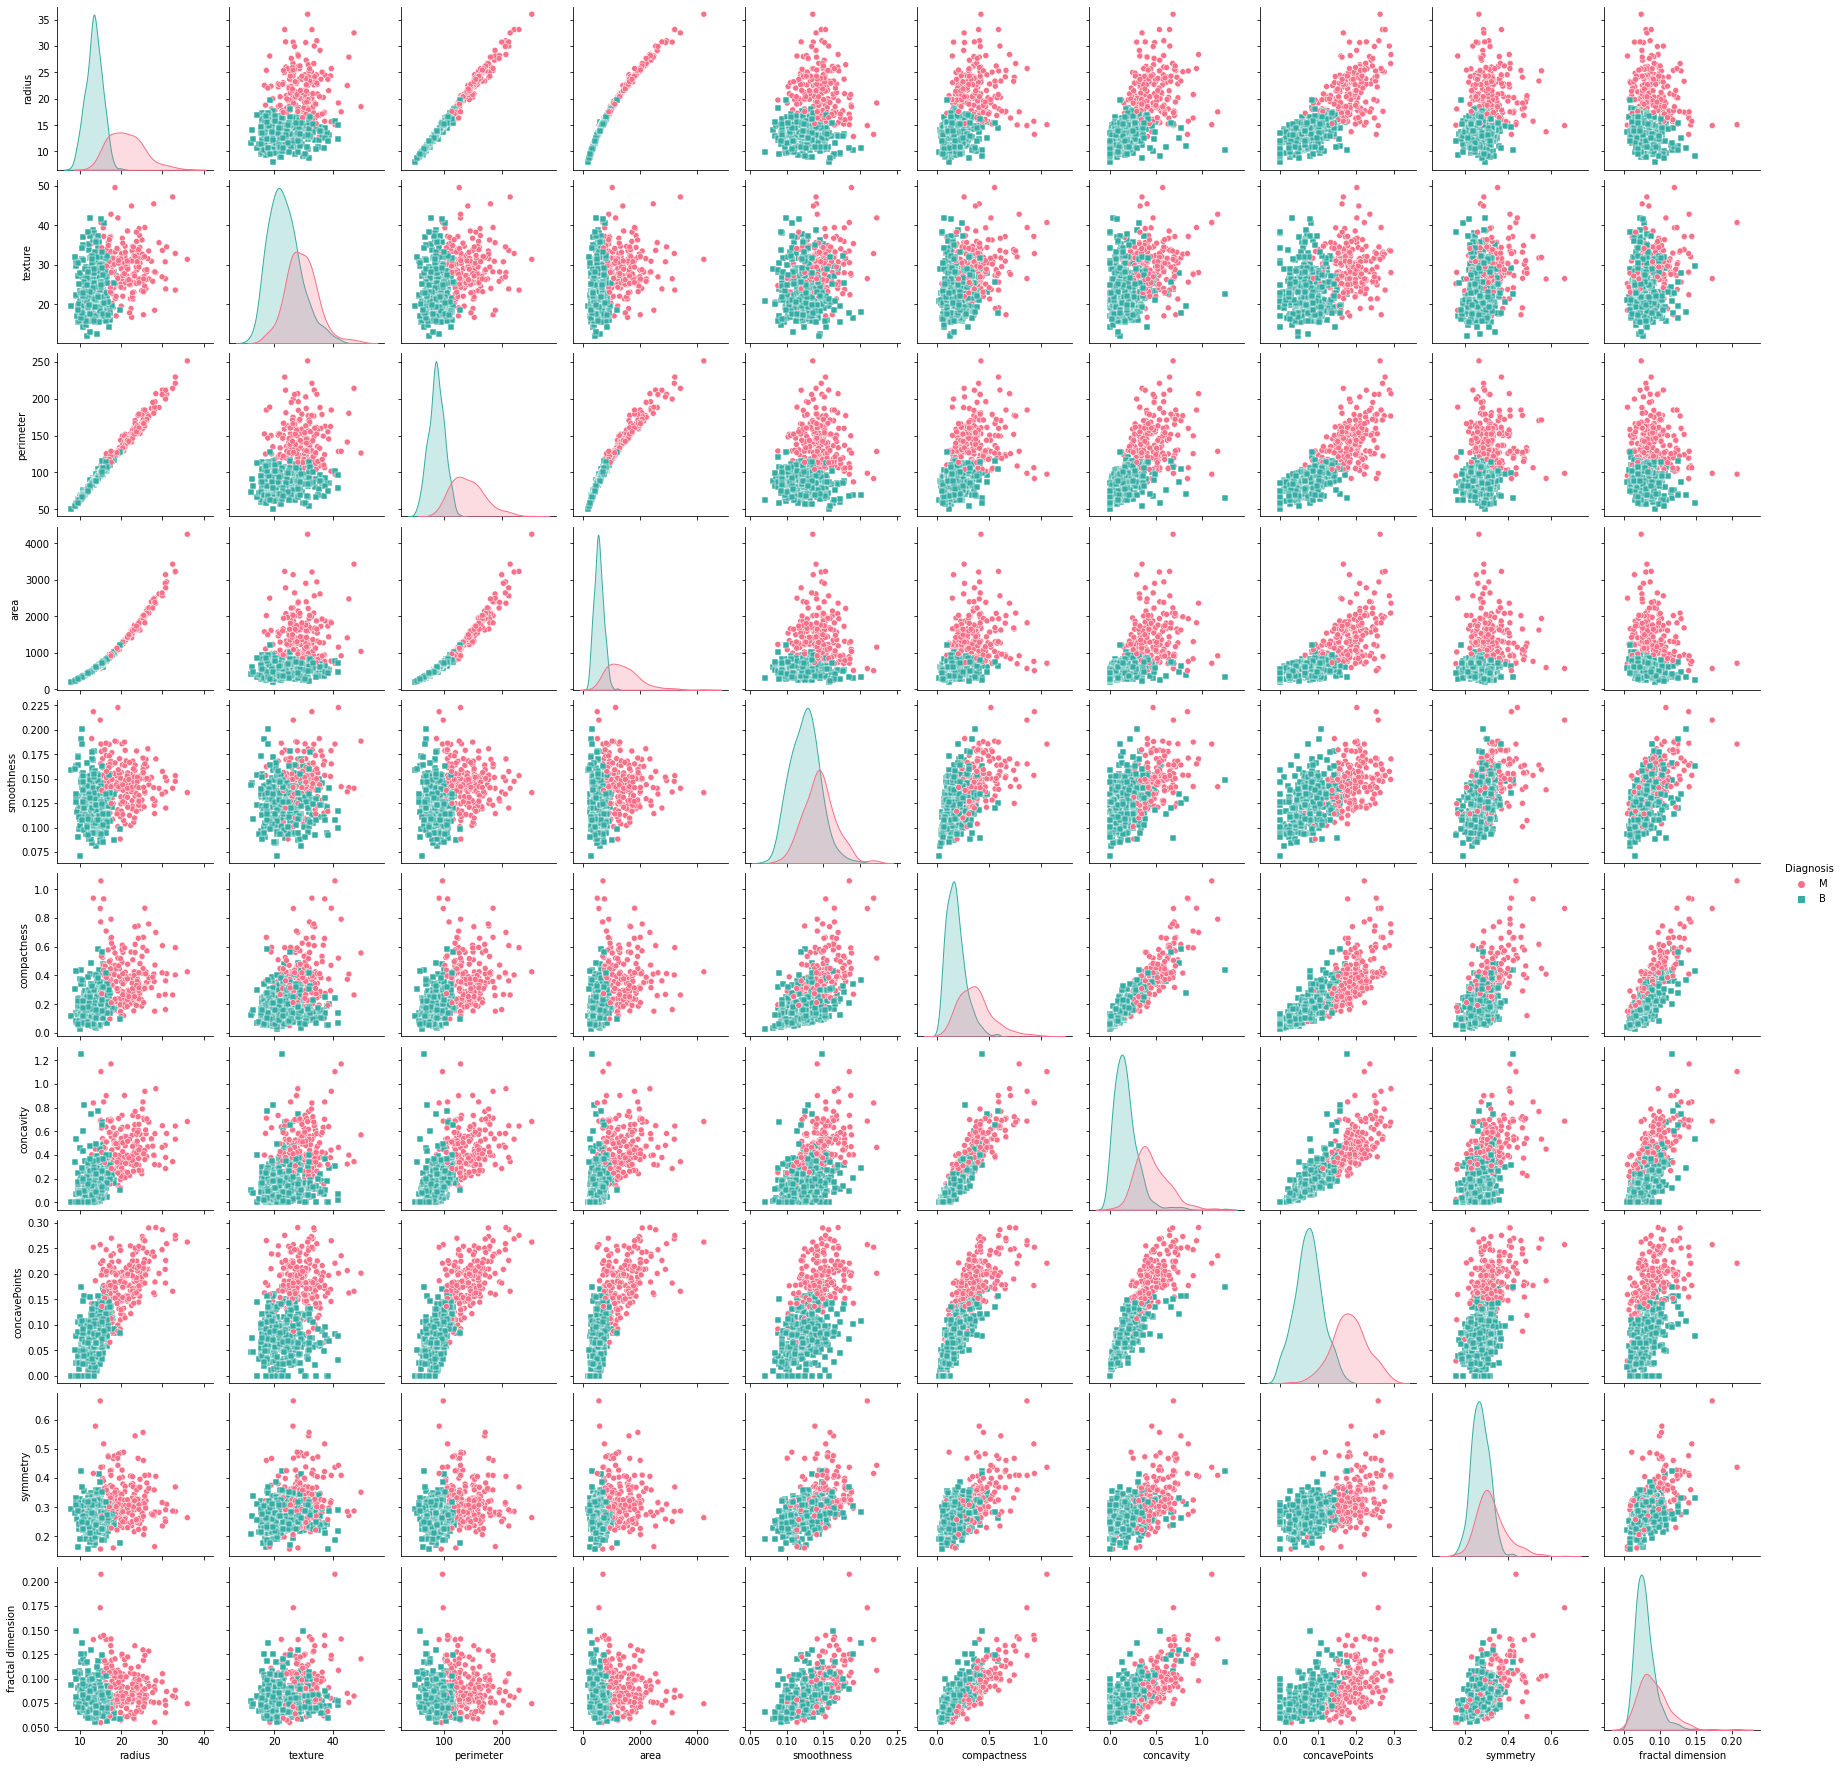

In [12]:
g = sns.pairplot(dat_worst, hue="Diagnosis", palette="husl", markers=["o", "s"])

# Select predictors with significant beta values #

In [13]:
def plot_traces(traces, retain=0):
    '''
    Convenience function:
    Plot traces with overlaid means and values
    '''
    ax = pm.traceplot(traces[-retain:],
                      lines=tuple([(k, {}, v['mean'])
                                   for k, v in pm.summary(traces[-retain:]).iterrows()]))
    for i, mn in enumerate(pm.summary(traces[-retain:])['mean']):
        ax[i,0].annotate('{:.2f}'.format(mn), xy=(mn,0), xycoords='data'
                    ,xytext=(5,10), textcoords='offset points', rotation=90
                    ,va='bottom', fontsize='large', color='#AA0022')

In [14]:
with pm.Model() as model:
    betas = pm.glm.GLM.from_formula(formula = 'Diagnosis~concavity+symmetry', 
                            data = dat_avg, 
                            family = pm.glm.families.Binomial())

    trace = pm.sample(500, step = pm.NUTS(target_accept = 0.99), cores = 6, tune=5000) # change cores if you need to 

Multiprocess sampling (6 chains in 6 jobs)
NUTS: [symmetry, concavity, Intercept]


Sampling 6 chains for 5_000 tune and 500 draw iterations (30_000 + 3_000 draws total) took 283 seconds.
The number of effective samples is smaller than 25% for some parameters.


In [15]:
trace.varnames

['Intercept', 'concavity', 'symmetry']

C:\Users\joony\anaconda3\lib\site-packages\arviz\data\io_pymc3.py:91: FutureWarning: Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less useful results. Make sure you use the model argument or call from_pymc3 within a model context.
  FutureWarning,
C:\Users\joony\anaconda3\lib\site-packages\arviz\data\io_pymc3.py:91: FutureWarning: Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less useful results. Make sure you use the model argument or call from_pymc3 within a model context.
  FutureWarning,
C:\Users\joony\anaconda3\lib\site-packages\arviz\data\io_pymc3.py:91: FutureWarning: Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less useful results. Make sure you use the model argument or call from_pymc3 within a model context.
  FutureWarning,


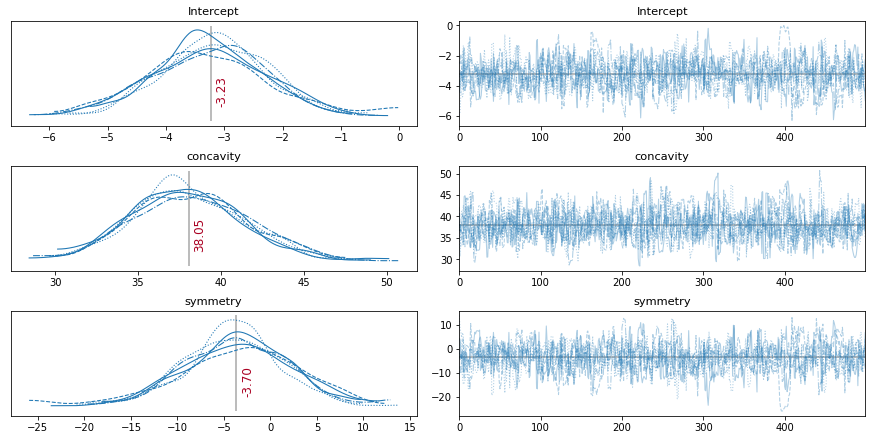

In [16]:
plot_traces(trace)

C:\Users\joony\anaconda3\lib\site-packages\arviz\data\io_pymc3.py:91: FutureWarning: Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less useful results. Make sure you use the model argument or call from_pymc3 within a model context.
  FutureWarning,


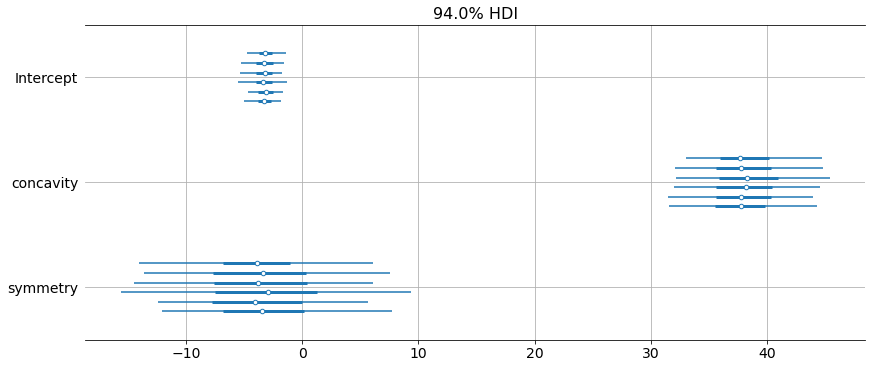

In [17]:
pm.plots.forestplot(trace, figsize=(12, 5))
# The creates a matplotlib plot, so we can modify with standard matplotlib commands
plt.grid()  # add a grid to the plot

### Drop "symmetry" attribute as it has a beta value not significantly different from 0 ###

In [18]:
data_avg = dat_avg[['Diagnosis', 'concavity']]

## Build the first model of the sequential model that all data points will be run on ##

In [19]:
with pm.Model() as model:
    betas = pm.glm.GLM.from_formula(formula = 'Diagnosis~concavity', 
                            data = data_avg, 
                            family = pm.glm.families.Binomial())
    pred = pm.Data("pred", data_avg.concavity)
    trace = pm.sample(500, step = pm.NUTS(target_accept = 0.99), cores = 6, tune=5000) # change cores if you need to

Multiprocess sampling (6 chains in 6 jobs)
NUTS: [concavity, Intercept]


Sampling 6 chains for 5_000 tune and 500 draw iterations (30_000 + 3_000 draws total) took 95 seconds.
The number of effective samples is smaller than 25% for some parameters.


In [20]:
trace.varnames

['Intercept', 'concavity']

C:\Users\joony\anaconda3\lib\site-packages\arviz\data\io_pymc3.py:91: FutureWarning: Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less useful results. Make sure you use the model argument or call from_pymc3 within a model context.
  FutureWarning,
C:\Users\joony\anaconda3\lib\site-packages\arviz\data\io_pymc3.py:91: FutureWarning: Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less useful results. Make sure you use the model argument or call from_pymc3 within a model context.
  FutureWarning,
C:\Users\joony\anaconda3\lib\site-packages\arviz\data\io_pymc3.py:91: FutureWarning: Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less useful results. Make sure you use the model argument or call from_pymc3 within a model context.
  FutureWarning,


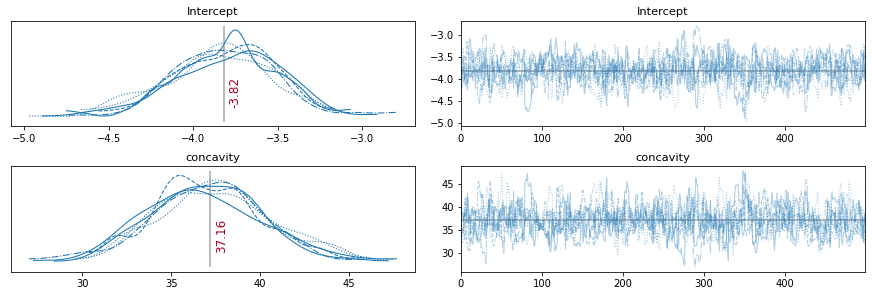

In [21]:
plot_traces(trace)

with model:
    ppc = pm.sample_posterior_predictive(trace,var_names=["p"], samples=500, progressbar=False)

C:\Users\joony\anaconda3\lib\site-packages\arviz\data\io_pymc3.py:91: FutureWarning: Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less useful results. Make sure you use the model argument or call from_pymc3 within a model context.
  FutureWarning,


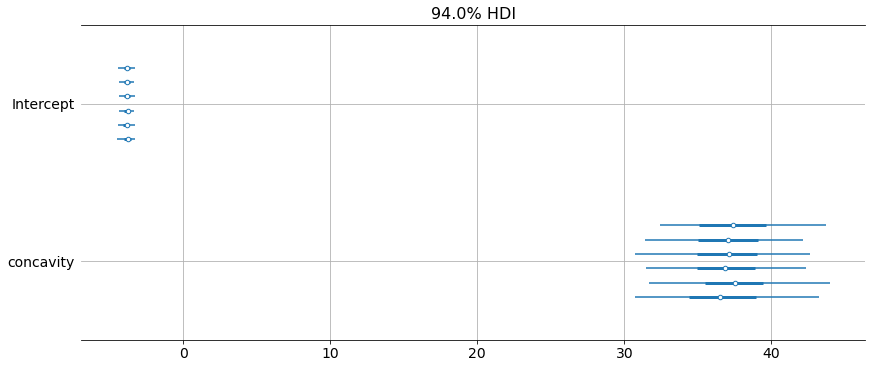

In [22]:
pm.plots.forestplot(trace, figsize=(12, 5))
# The creates a matplotlib plot, so we can modify with standard matplotlib commands
plt.grid()  # add a grid to the plot

## Compute the posterior probabilities of the training set and testing set ##

In [23]:
with model:
    p_original = pm.Deterministic("p_original", pm.math.invlogit(betas['Intercept'] + betas['concavity'] * pred))
    # use the updated values and predict outcomes and probabilities:
    model_preds_original = pm.sample_posterior_predictive(
        trace, var_names = ["p_original"],random_seed = 101
    )["p_original"]

In [24]:
predictors_out_of_sample = dat_worst['concavity']
outcomes_out_of_sample = dat_worst['Diagnosis']
with model:
    # update values of predictors:
    pm.set_data({"pred": predictors_out_of_sample})
    p = pm.Deterministic("p", pm.math.invlogit(betas['Intercept'] + betas['concavity'] * pred))
    # use the updated values and predict outcomes and probabilities:
    model_preds = pm.sample_posterior_predictive(
        trace, var_names = ["p"],random_seed = 101
    )["p"]

## Visualize the prediction result ##

### Training data ###

C:\Users\joony\anaconda3\lib\site-packages\arviz\stats\stats.py:338: UserWarning: hpd will be deprecated Please replace hdi
  ("hpd will be deprecated " "Please replace hdi"),
C:\Users\joony\anaconda3\lib\site-packages\arviz\stats\stats.py:487: FutureWarning: hdi currently interprets 2d data as (draw, shape) but this will change in a future release to (chain, draw) for coherence with other functions
  FutureWarning,


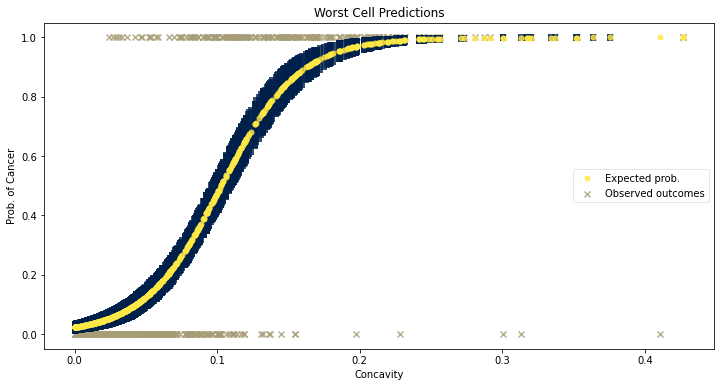

In [25]:
predictors_in_of_sample = data_avg['concavity']
outcomes_in_of_sample = data_avg['Diagnosis']
_, ax = plt.subplots(figsize=(12, 6))

# uncertainty about the estimates:
ax.plot(
    [predictors_in_of_sample, predictors_in_of_sample],
    az.hpd(model_preds_original).T,
    lw=6,
    color="#00204C",
    alpha=0.8,
)
# expected probability of success:
ax.plot(
    predictors_in_of_sample,
    model_preds_original.mean(0),
    "o",
    ms=5,
    color="#FFE945",
    alpha=0.8,
    label="Expected prob.",
)

numerical_diagnosis = []

for x in outcomes_out_of_sample:
        if x == 'M':
            y=1
        elif x == 'B':
            y=0
        numerical_diagnosis.append(y)

# actual outcomes:
ax.scatter(
    
    x=predictors_in_of_sample,
    y=numerical_diagnosis,
    marker="x",
    color="#A69C75",
    alpha=0.8,
    label="Observed outcomes",
)

ax.set_xlabel("Concavity")
ax.set_ylabel("Prob. of Cancer")
ax.set_title("Worst Cell Predictions")
ax.legend(fontsize=10, frameon=True, framealpha=0.5);

### Testing data ###

C:\Users\joony\anaconda3\lib\site-packages\arviz\stats\stats.py:338: UserWarning: hpd will be deprecated Please replace hdi
  ("hpd will be deprecated " "Please replace hdi"),
C:\Users\joony\anaconda3\lib\site-packages\arviz\stats\stats.py:487: FutureWarning: hdi currently interprets 2d data as (draw, shape) but this will change in a future release to (chain, draw) for coherence with other functions
  FutureWarning,


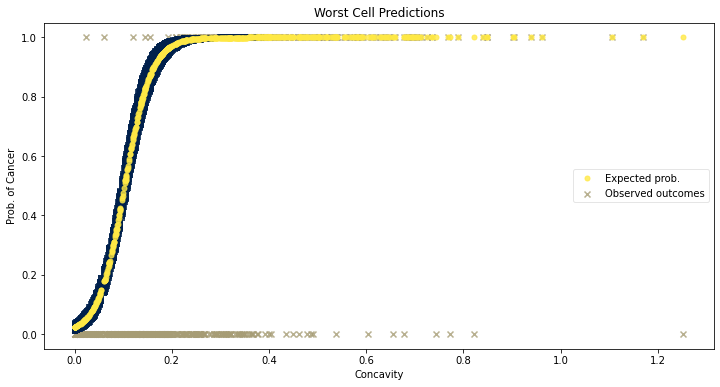

In [26]:
_, ax = plt.subplots(figsize=(12, 6))

# uncertainty about the estimates:
ax.plot(
    [predictors_out_of_sample, predictors_out_of_sample],
    az.hpd(model_preds).T,
    lw=6,
    color="#00204C",
    alpha=0.8,
)
# expected probability of success:
ax.plot(
    predictors_out_of_sample,
    model_preds.mean(0),
    "o",
    ms=5,
    color="#FFE945",
    alpha=0.8,
    label="Expected prob.",
)
           
# actual outcomes:
ax.scatter(
    
    x=predictors_out_of_sample,
    y=numerical_diagnosis,
    marker="x",
    color="#A69C75",
    alpha=0.8,
    label="Observed outcomes",
)

ax.set_xlabel("Concavity")
ax.set_ylabel("Prob. of Cancer")
ax.set_title("Worst Cell Predictions")
ax.legend(fontsize=10, frameon=True, framealpha=0.5);

## Select uncertain data points ##

### Select the data points if 0.5 is within 1 standard deviation away from the mean of the posterior probability ###

In [27]:
data_avg["p"] = model_preds_original.mean(axis=0)
data_avg["std"] = model_preds_original.std(axis=0)
data_avg["diff"] = abs(data_avg["p"] - 0.5)

C:\Users\joony\anaconda3\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.
C:\Users\joony\anaconda3\lib\site-packages\ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
C:\Users\joony\anaconda3\lib\site-packages\ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in

In [28]:
dat_worst["p"] = model_preds.mean(axis=0)
dat_worst["std"] = model_preds.std(axis=0)
dat_worst["diff"] = abs(dat_worst["p"] - 0.5)

In [29]:
data_avg_uncert = data_avg.query("diff < std")
data_avg_uncert.shape

(17, 5)

In [30]:
data_worst_uncert = dat_worst.query("diff < std")
data_worst_uncert.shape

(12, 14)

## Build the second model of the sequatial model with the uncertain training data points ##

In [31]:
with pm.Model() as second_model:
    pred2 = pm.Data("pred2", data_avg_uncert.concavity)
    betas2 = pm.glm.GLM.from_formula(formula = 'Diagnosis~concavity', 
                            data = data_avg_uncert, 
                            family = pm.glm.families.Binomial())
    
    trace_2 = pm.sample(500, step = pm.NUTS(target_accept = 0.99), cores = 6, tune=5000) # change cores if you need to 

Multiprocess sampling (6 chains in 6 jobs)
NUTS: [concavity, Intercept]


Sampling 6 chains for 5_000 tune and 500 draw iterations (30_000 + 3_000 draws total) took 118 seconds.
The acceptance probability does not match the target. It is 0.9616386080916403, but should be close to 0.99. Try to increase the number of tuning steps.
The number of effective samples is smaller than 25% for some parameters.


In [32]:
trace_2.varnames

['Intercept', 'concavity']

C:\Users\joony\anaconda3\lib\site-packages\arviz\data\io_pymc3.py:91: FutureWarning: Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less useful results. Make sure you use the model argument or call from_pymc3 within a model context.
  FutureWarning,
C:\Users\joony\anaconda3\lib\site-packages\arviz\data\io_pymc3.py:91: FutureWarning: Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less useful results. Make sure you use the model argument or call from_pymc3 within a model context.
  FutureWarning,
C:\Users\joony\anaconda3\lib\site-packages\arviz\data\io_pymc3.py:91: FutureWarning: Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less useful results. Make sure you use the model argument or call from_pymc3 within a model context.
  FutureWarning,


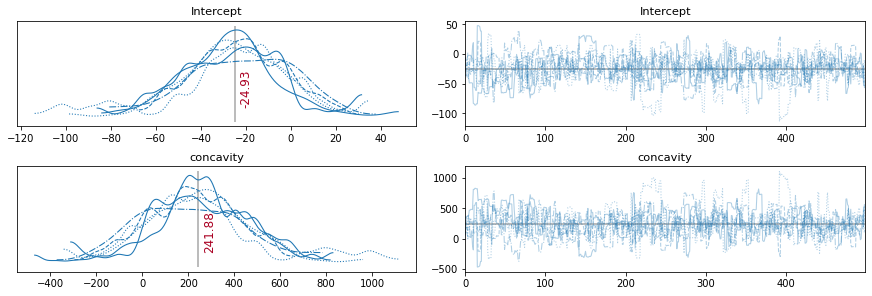

In [33]:
plot_traces(trace_2)

C:\Users\joony\anaconda3\lib\site-packages\arviz\data\io_pymc3.py:91: FutureWarning: Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less useful results. Make sure you use the model argument or call from_pymc3 within a model context.
  FutureWarning,


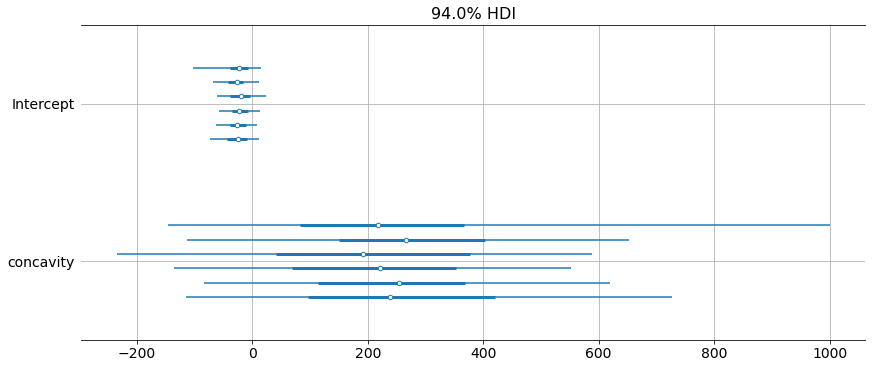

In [34]:
pm.plots.forestplot(trace_2, figsize=(12, 5))
# The creates a matplotlib plot, so we can modify with standard matplotlib commands
plt.grid()  # add a grid to the plot

## Compute the posterior probabillities with the second model on the uncertain points ##

In [35]:
with second_model:
    p_original2 = pm.Deterministic("p_original2", pm.math.invlogit(betas2['Intercept'] + betas2['concavity'] * pred2))
    # use the updated values and predict outcomes and probabilities:
    model_preds_original2 = pm.sample_posterior_predictive(
        trace_2, var_names = ["p_original2"],random_seed = 101
    )["p_original2"]

In [36]:
predictors_out_of_sample2 = data_worst_uncert['concavity']
outcomes_out_of_sample2 = data_worst_uncert['Diagnosis']
with second_model:
    # update values of predictors:
    pm.set_data({"pred2": predictors_out_of_sample2})
    p2 = pm.Deterministic("p2", pm.math.invlogit(betas2['Intercept'] + betas2['concavity'] * pred2))
    # use the updated values and predict outcomes and probabilities:
    model_preds2 = pm.sample_posterior_predictive(
        trace_2, var_names = ["p2"],random_seed = 101
    )["p2"]

C:\Users\joony\anaconda3\lib\site-packages\arviz\stats\stats.py:338: UserWarning: hpd will be deprecated Please replace hdi
  ("hpd will be deprecated " "Please replace hdi"),
C:\Users\joony\anaconda3\lib\site-packages\arviz\stats\stats.py:487: FutureWarning: hdi currently interprets 2d data as (draw, shape) but this will change in a future release to (chain, draw) for coherence with other functions
  FutureWarning,


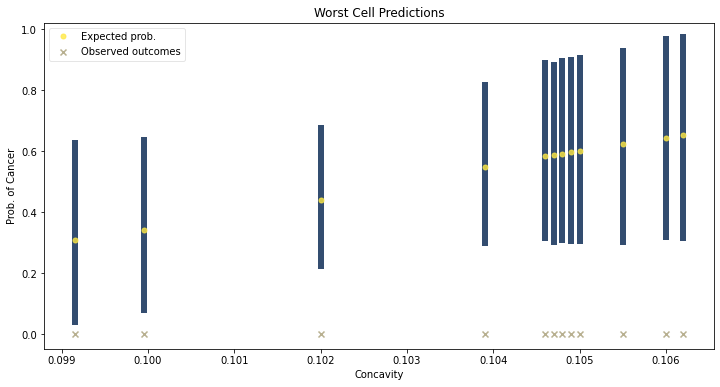

In [37]:
_, ax = plt.subplots(figsize=(12, 6))

# uncertainty about the estimates:
ax.plot(
    [predictors_out_of_sample2, predictors_out_of_sample2],
    az.hpd(model_preds2).T,
    lw=6,
    color="#00204C",
    alpha=0.8,
)

# expected probability of success:
ax.plot(
    predictors_out_of_sample2,
    model_preds2.mean(0),
    "o",
    ms=5,
    color="#FFE945",
    alpha=0.8,
    label="Expected prob.",
)
numerical_diagnosis2 = []

for x in outcomes_out_of_sample2:
        if x == 'M':
            y=1
        elif x == 'B':
            y=0
        numerical_diagnosis2.append(y)
           
# actual outcomes:
ax.scatter(
    
    x=predictors_out_of_sample2,
    y=numerical_diagnosis2,
    marker="x",
    color="#A69C75",
    alpha=0.8,
    label="Observed outcomes",
)

ax.set_xlabel("Concavity")
ax.set_ylabel("Prob. of Cancer")
ax.set_title("Worst Cell Predictions")
ax.legend(fontsize=10, frameon=True, framealpha=0.5);